In [1]:
pwd

'/home/vmu/nu_stats'

In [2]:
%cd examples/bayes_hierarchical_model/

/home/vmu/nu_stats/examples/bayes_hierarchical_model


In [3]:
import dill

In [ ]:
dill.load_session('notebook_env.db')

In [ ]:
dill.dump_session('notebook_env.db')

In [4]:
%load_ext autoreload
%autoreload 2

# SIM

In [5]:
from astropy import units as u
import numpy as np
from cmdstanpy import CmdStanModel
import arviz, corner
from matplotlib import pyplot as plt

In [6]:
import sys
sys.path.append("../../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [7]:
# Choose simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-16 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [8]:
sim = Simulation(L, gamma, z, F_diff_norm, Emin, Emax, Enorm)
sim.run(seed=42)


Simulated 39 events


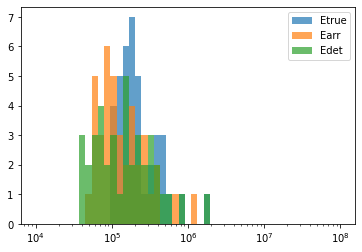

In [9]:
sim.show_spectrum()

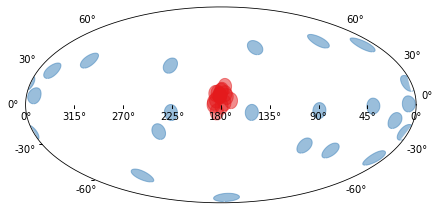

In [10]:
sim.show_skymap()

In [11]:
sim.truth

OrderedDict([('L', 6.2415090744607645e+50),
             ('gamma', 2.2),
             ('F_diff', 8.331240094640408e-08),
             ('f', <Quantity 0.36624602>)])

In [12]:
sim.labels

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0])

In [13]:
# Extract simulated data and get info needed for fit
fit_input = sim.get_data()

In [14]:
fit_input

OrderedDict([('N', 39),
             ('Edet',
              array([ 160494.5938574 ,  301492.05941278,   98365.02946014,
                      124559.60563702,  325742.64786662,  237575.94503549,
                       64972.13486349,   78925.11678329,  563612.79241109,
                       85148.29895773,  142051.42558954, 1883647.18745385,
                      217222.21262399,   40062.79683038,  450155.35016338,
                       70754.4930768 ,   41779.98531686,  161282.21348771,
                      370044.03861468,  352102.90081269,  280037.38660527,
                       85800.17352267,  172962.05588992,  106541.37394527,
                      373861.64327788,   97225.2783876 ,   73633.41710957,
                      139767.65205004,   50460.01545192,  197499.51009756,
                       76965.50518939,   59704.79626241,   51996.36306348,
                       56675.83399277,  240532.578054  ,  787206.48802644,
                       42041.08951639,  142836.1135131

# FQTIST FIT

In [23]:
bg_sim = Simulation(0*u.erg/u.s, gamma, z, F_diff_norm, Emin, Emax, Enorm, 1000000)
bg_sim.run(seed=12345678)
bg_dat = bg_sim.get_data()

Simulated 1000000 events


In [24]:
bg_sim.truth

OrderedDict([('L', 0.0),
             ('gamma', 2.2),
             ('F_diff', 8.331240094640408e-08),
             ('f', <Quantity 0.>)])

In [25]:
from nu_stats.fqutils import FqStructure

In [26]:
fq = FqStructure(z, Emin,Emax, Esim_gamma = 1.5, n_Esim=10000) # With energy part

/home/vmu/Envs/exj/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Simulated 10000 events
Marginalized energy likelihood generated.


In [27]:
fq_noE = FqStructure()

Marginalized energy likelihood taken to be 1.


In [30]:
## get p values
sim_TS, bg_TS, sim_p = fq.event_statistics(fit_input, bg_dat, 2)
## set label 0 for p<.01 and 1 for p>=.01
labels = (sim_p >=.01).astype(int)

1.0592888325595393
spacial 2.1231069146060107e-101
energy  1.0045845462045606
spacial 2.0965483303004053e-62
energy  1.0592888325595393
spacial 1.5773941684102276e-164
energy  1.0045845462045606
spacial 2.0370512286242356e-99
energy  0.12766612607508082
spacial 0.32278889537596495
energy  0.12766612607508082
spacial 3.3349381904888523e-91
energy  0.7237017969299434
spacial 1.5917549923653215e-35
energy  0.7250835747606187
spacial 1.386857239666961e-38
energy  0.12766612607508082
spacial 2.39067622546846e-96
energy  0.0
spacial 5.983012496319021e-31
energy  0.7250835747606187
spacial 4.271342055186897e-139
energy  1.0045845462045606
spacial 4.5168349733487546e-100
energy  0.7237017969299434
spacial 4.312089820553171e-109
energy  1.0045845462045606
spacial 2.535161223081113e-162
energy  0.07553142183977557
spacial 9.518918582741623e-155
energy  1.0592888325595393
spacial 0.9724332758734808
energy  0.33506070059185983
spacial 1.2517444698972013e-110
energy  0.9939058240469085
spacial 1.24

KeyboardInterrupt: 

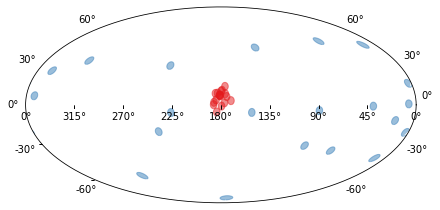

In [29]:
u_v_s(fit_input['det_dir'], labels);

In [22]:
np.mean(labels)

0.5641025641025641

In [81]:
bg_TS.sort()

In [82]:
frac = lambda x: np.mean(bg_TS > x)
y = np.array([frac(elem) for elem in bg_TS])

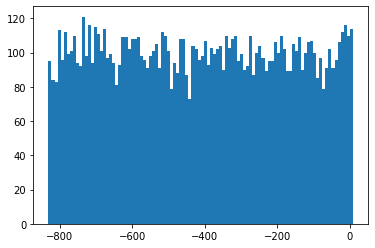

In [83]:
plt.hist(bg_TS,bins=100);

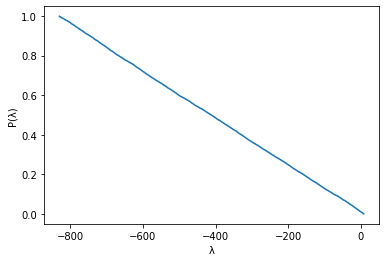

In [84]:

plt.step(bg_TS, y);
plt.xlabel('λ');
plt.ylabel('P(λ)');
#plt.yscale('log');

# BHM

In [ ]:
stan_model = CmdStanModel(stan_file="stan/toy_bhm.stan")
fit = stan_model.sample(data=fit_input, iter_sampling=1000, chains=4, seed=42)

In [ ]:
# Trace plot
var_names = ["L", "F_diff", "f", "gamma"]
arviz.plot_trace(fit, var_names=var_names);


In [ ]:
# Corner plot, comparing with truth form sim
variables = fit.stan_variables()
samples = np.column_stack([variables[key] for key in var_names])
truths_list = [sim.truth[key] for key in var_names]

corner.corner(samples, labels=var_names, truths=truths_list);

In [ ]:
fit.diagnose()


In [ ]:
fit.summary()

In [ ]:
fit.stan_variable('log_prob').shape

## Individual associations


In [31]:
import nu_stats.bhmutils as bhm

In [32]:
association = bhm.classify_events(fit_input, fit)

In [33]:
labels_b = (association[:,0] <.01).astype(int)

In [34]:
labels_b

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0])

In [35]:
labels_b.mean()

0.5384615384615384

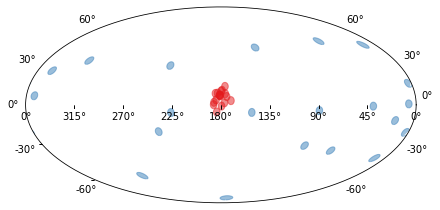

In [36]:
u_v_s(det_dir, labels_b);